# Machine Learning for Side-Channel Analysis

_Adrien Chuttarsing & Luca Veyrin-Forrer & Malik Kazi Aoual & Martin Bauw & Nouredine Nour_

> ## 1. Challenge introduction

> ## 2. Business case

>> ### 2.1  Embedded encryption, data and IoT
>> ### 2.2 Challenge metric and Key Performance Indicator

> ## 3. Exploratory data analysis

> ## 4. Baseline solution

> ## 5. Making a RAMP submission

# 1. Challenge introduction

This challenge is about revealing the relevance of machine learning in the field of a certain type of cyber attack: the Side-Channel Attack (SCA). SCA harvests Side-Channel Analysis information in order to breach a protected system. This information consists in physical measurements associated with the hardware on which the cryptographic algorithms are implemented. Here, we consider the use of electromagnetic measurements of the activity of a smart card as a side-channel to attack an AES encryption implementation. The project was inspired by the work of an ANSSI and CEA team formalized in a research article *Study of Deep Learning Techniques for Side-Channel Analysis and Introduction to ASCAD Database* (authors: Emmanuel Prouff, Remi Strullu, Ryad Benadjila, Eleonora Cagli, Cécile Dumas).

The overall advent of AI doesn't go without impacting cybersecurity, a growing and essential field for any economy in our digitalized world. Ernst and Young reports an expected **global cost of 6 trillions US dollars for cybersecurity breaches across all sectors by 2021**.

# 2. Business case

## 2.1  Embedded encryption, data and IoT

This challenge focuses on the ability of **machine learning to help in the cracking of encryption in small hardware that would typically be embedded in IoT devices**. IoT devices are central among the cybersecurity concerns, since the upcoming IoT revolution translates into a massive introduction of connected devices among networks, which is directly associated with a wealth of personal and sensitive data. 

![Connected devices growth curve](images/connecteddevices.png)
**Image credit:** The Economist

Connected devices have a history of being targeted by cyber attacks since many of them aren't well protected when one considers the interest of the data if gives access to. According to the EU 2017 cybersecurity facts sheet, **there will be tens of billions of connected digital devices in the EU alone by 2020**.

Furthermore, working on AES (Advanced Encryption Standard) gives substantial legitimacy to machine learning as a prominent player in cybersecurity, since it is a US federal government standard. AES is a symmetric key algorithm, a unique key is shared by both encryption and decryption processes. Depending on key length, AES is even said to be used to secure US classified information (with 192 or 256 bits keys). Here, the AES implementation being attacked relies on 16-byte/128 bits keys. The technique used to find the secret key actually recovers the latter byte by byte, see the paper cited in the introduction for additional details. Finally, **AES was initially selected for its speed and low RAM requirements, making it well suited for both powerful computers and 8-bit smart cards**. This only reinforces the relevance of this challenge regarding the future of cybersecurity and IoT in particular.

## 2.2 Challenge metric and Key Performance Indicator

SCAs divide themselves into two categories: non-profiling and profiling SCAs. The first category means the attacker only has access to external physical measurements to hack a system. **The second one implies that the attacker has a copy of the system it's trying to hack. This means he can manually identify the possible correlation between external physical measurements and what happens on the device** (thus the word "profiling"), before attacking a similar device he doesn't operate himself. **This work is associated with the second category of SCA**.

Our profiling SCA has two phases: **a profiling step**, and an **attack step**. During the profiling step, the label being the byte of key (partial key) associated with the trace (labelled electromagnetic measurements), the classifier learns which traces go with which byte. Note that later in this notebook the nature of traces labels won't be bytes since the data set uses a function that takes those secret key parts as inputs (see article for details). It isn't a problem since understanding this subtle labelling is not required to understand how the challenge's scores are determined (see below).

During the attack step, a decision has to be found on which byte is the most probable candidate for the byte of the secret key we are facing in the test data/traces. The evolution of your classifier's performance will be illustrated by a (traces,rank) graph. **The traces number (x axis)** describes how many traces of the attack step (test data) you have processed until now in the current set. **The rank (y axis)** describes, thanks to a maximum likelihood estimation, how many secret key bytes your model think are more probably the one we want than the one we actually want. **Another way to understand the rank** is to say that when it diminishes, less false secret key bytes are thought to be the true secret key byte with a higher probability than the true secret key byte. In the end, you want to reach a rank as little as possible. This is where the test/validation phase could surprise you: you don't necessarily need the whole validation/test set of traces to achieve a "perfect" success. Indeed, once the only byte your model thinks is the secret byte, actually is, you don't need to process remaining electromagnetic traces ! **Your final score will be the area under this (traces,rank) curve**.

Again, note that classical scoring quantities, such as accuracy, aren't adapted to the nature of this challenge: the task isn't really about labelling each trace of the attack set, but rather to use as few traces of this set as possible in order do disqualify the wrong secrete keys for the AES implementation being attacked. **Imagine you have reached an optimal rank, meaning you know which byte is the secret one, without considering half of the test traces. That could mean you have done well, without having achieved a high accuracy**.

Defining a **key performance indicator** regarding this project basically means fixing the value of what the encryption is protecting. The thing is, we are targeting here a typical embedded security mean, that could be linked to sensible data in any industry. In order to still find a way of defining **an order of magnitude of the amount of money behind our challenge's scores**, let's assume our AES encryption will systematically protect one record for one type of industry. The table below, "Cost per record lost (...)", indicates exactly **how much money the cracking of the secret key is actually worth**: it ranges from an unclear "public" record at **86 US dollars**, to a "health" personal record, at **402 US dollars**. To realize the relevance of this machine learning application, **multiply those sums of money with the number of IoT devices expected in the years to come** (previous illustration).

In [1]:
## Source https://www.calyptix.com/wp-content/uploads/healthcare-data-breach-cost-per-record.jpg
from IPython.display import Image
source = 'https://www.calyptix.com/wp-content/uploads/healthcare-data-breach-cost-per-record.jpg'
Image(url = source, width=700, height=200)

# 3. Exploratory data analysis
## Description of the data

We will use for this challenge an open database, named ASCAD, containing useful data for our side-channel experimentations. As precised previously, the dataset we will use consists of electromagnetic traces. These traces are composed of 700 features.


- each row in the dataframe is a trace
- each trace is composed of electromagnetic measurements zoomed in on the 700 samples window of interest containing the relevant information (feature 0 to 700)

The main difficulty in this dataset is to interpret the features which are not easily understandable at the first approach.

### Requirements


In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from problem import get_train_data, get_test_data
import warnings
warnings.filterwarnings('ignore')

### Data loading

Here is the simplest way to load the data. The h5 file has to be in the data folder.

In [3]:
df_train, labels_train = get_train_data()
df_test, labels_valid = get_test_data()

X_train = df_train.values
X_valid = df_test.values

y_train = labels_train[:,0]
y_valid = labels_valid[:,0]

### A first glimpse on the data

In [4]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,690,691,692,693,694,695,696,697,698,699
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,19.988140,19.215220,14.979940,8.371440,0.590740,-7.690040,-16.481780,-25.824800,-35.337040,-43.645820,...,-50.366580,-45.824400,-41.853060,-37.731280,-31.992800,-23.645800,-13.219660,-2.214860,7.235560,13.70676
std,2.756678,2.856043,3.127589,3.253264,3.150778,3.083873,3.083877,3.130045,2.970593,2.475944,...,1.688128,1.560966,1.428786,1.641634,2.285531,3.008622,3.475504,3.363897,2.729106,1.87719
min,10.000000,9.000000,3.000000,-3.000000,-10.000000,-17.000000,-26.000000,-35.000000,-44.000000,-52.000000,...,-56.000000,-51.000000,-47.000000,-43.000000,-38.000000,-32.000000,-22.000000,-13.000000,-1.000000,7.00000
25%,18.000000,17.000000,13.000000,6.000000,-2.000000,-10.000000,-19.000000,-28.000000,-38.000000,-46.000000,...,-52.000000,-47.000000,-43.000000,-39.000000,-34.000000,-26.000000,-16.000000,-5.000000,5.000000,12.00000
50%,20.000000,19.000000,15.000000,8.000000,0.000000,-8.000000,-16.000000,-26.000000,-35.000000,-44.000000,...,-50.000000,-46.000000,-42.000000,-38.000000,-32.000000,-24.000000,-13.000000,-2.000000,7.000000,14.00000
75%,22.000000,21.000000,17.000000,11.000000,3.000000,-5.000000,-14.000000,-23.000000,-33.000000,-42.000000,...,-49.000000,-45.000000,-41.000000,-37.000000,-30.000000,-21.000000,-10.000000,0.000000,9.000000,15.00000
max,30.000000,29.000000,26.000000,20.000000,12.000000,3.000000,-7.000000,-16.000000,-27.000000,-36.000000,...,-45.000000,-41.000000,-37.000000,-32.000000,-25.000000,-15.000000,-3.000000,7.000000,15.000000,20.00000


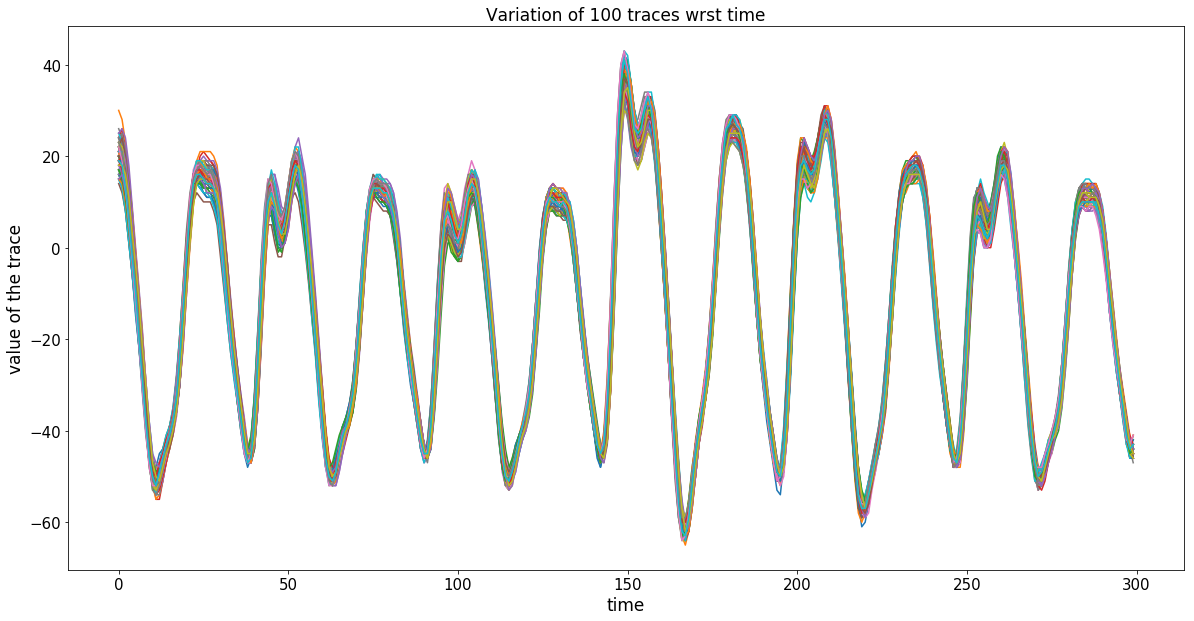

In [5]:
plt.figure(figsize=(20,10))
for i in [x*2 for x in range(100)]:
    plt.plot(X_train[i,:300])
plt.title("Variation of 100 traces wrst time",fontsize=17)
plt.xlabel("time",fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel("value of the trace",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

We have here the variation of ten electromagnetic traces over time. It looks like every trace has mainly the same behaviour. Indeed we could explain this by the fact that these traces are information leaked from the physical implementations of cryptographic algorithms which are, at this scale, analogous.

### The labels

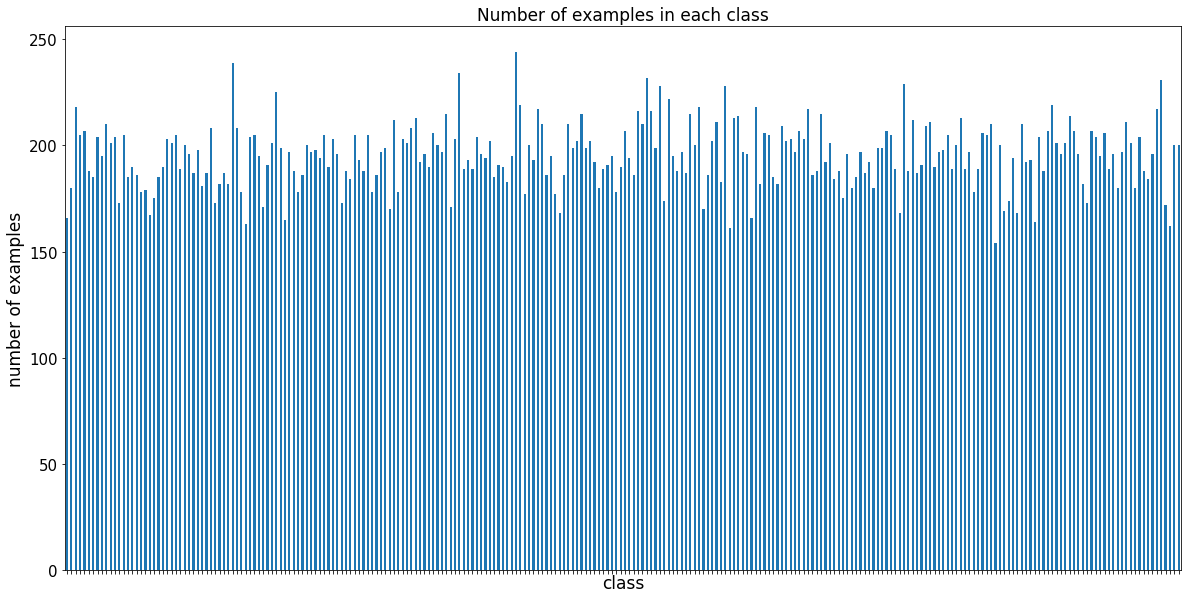

In [6]:
pd.DataFrame(np.unique(y_train, return_counts=True)[1]).plot(kind='bar', figsize=(20,10), legend=False)
plt.title("Number of examples in each class",fontsize=17)
plt.xlabel("class",fontsize=17)
plt.xticks(fontsize=15, visible=False)
plt.ylabel("number of examples",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

We see that we have 256 different labels. Furthermore, the dataset is quite balanced.

### The features

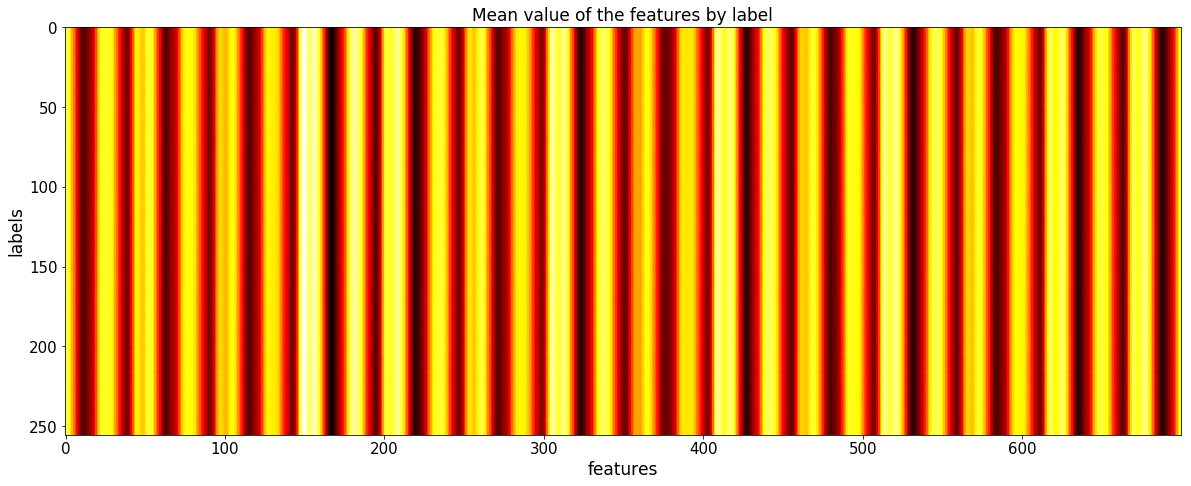

In [7]:
df_train_labelled = df_train.copy()
df_train_labelled[700] = y_train
u = df_train_labelled.groupby([700]).mean()

plt.figure(figsize=(20,10))

plt.imshow(u, cmap='hot', interpolation='nearest')
plt.title("Mean value of the features by label",fontsize=17)
plt.xlabel("features",fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel("labels",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

In this figure, we computed for each label, the mean of the value of each feature. We can notice here that the features have globally the same mean irrespective of the label.

Next we plot 5 traces from 5 different labels amoung the 256. We see that they look very close to each other like suggested above. It seems that the differences are located on the peaks.

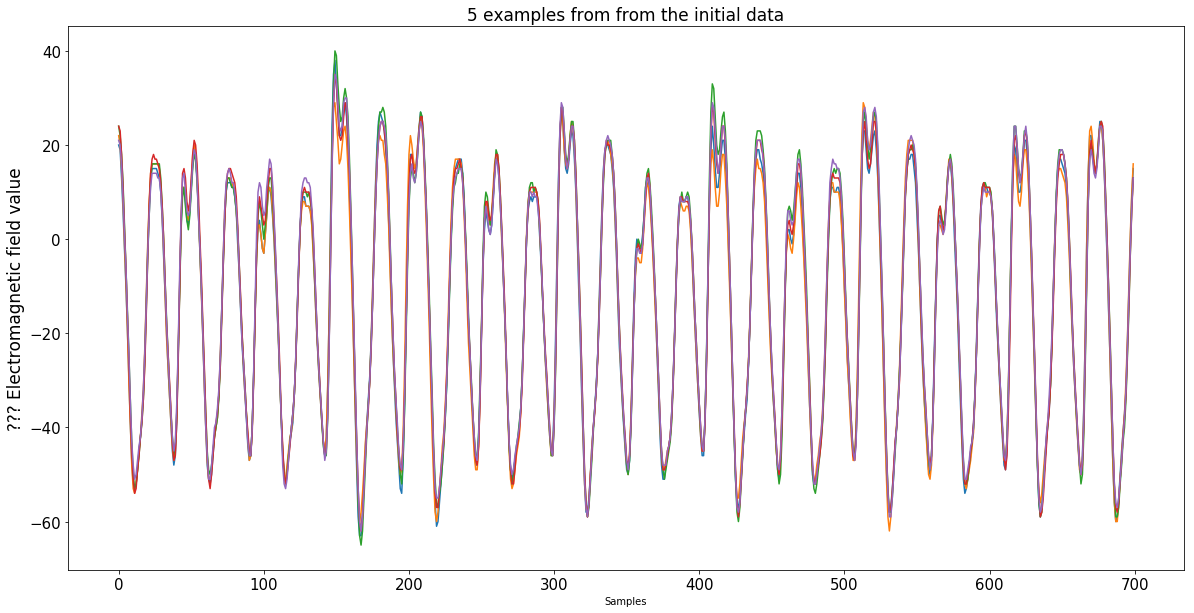

In [8]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.plot([i for i in range(700)], X_train[i])
plt.title("5 examples from from the initial data", fontsize=17)
plt.xlabel("Samples")
plt.xticks(fontsize=15, visible=True)
plt.ylabel("??? Electromagnetic field value", fontsize=17)
plt.yticks(fontsize=15)
plt.show()

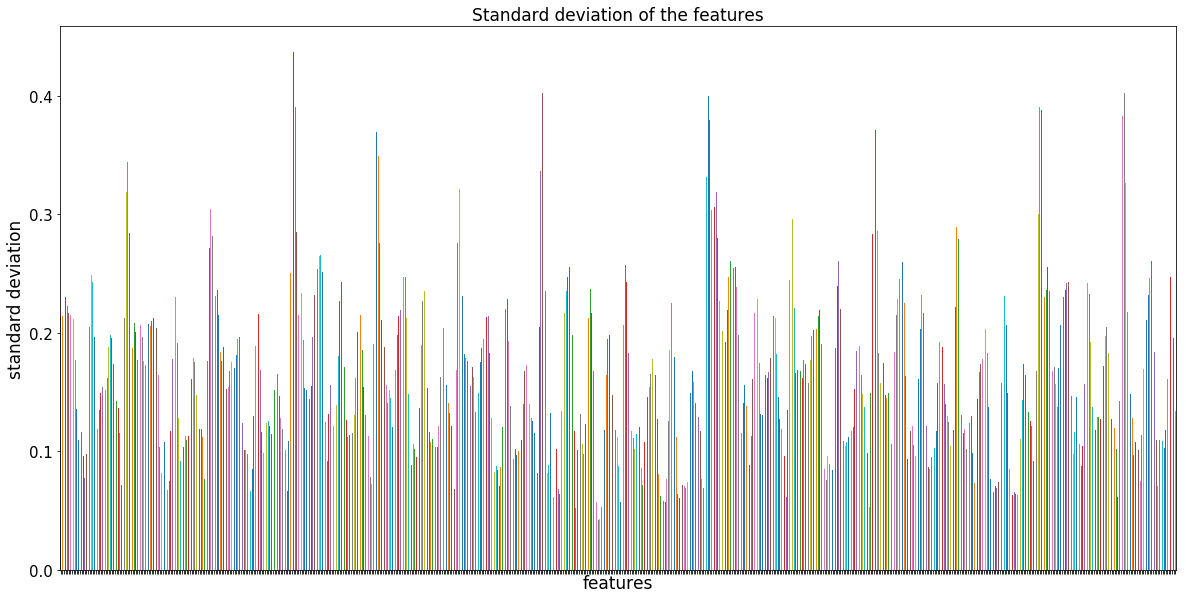

In [9]:
plt.figure(figsize=(20,10))
u.std().plot( kind='bar')
plt.title("Standard deviation of the features",fontsize=17)
plt.xlabel("features",fontsize=17)
plt.xticks(fontsize=15, visible=False)
plt.ylabel("standard deviation",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

From this point of view and in light of these experiences, it seems the different features have globally the same behaviour except some which have clearly a higher standard deviation. Maybe it could be smart to focus on these features for the model or if we would like to do a feature selection. 

To do so lets get the indices from which the variance is the highest: 

<Figure size 1440x720 with 0 Axes>

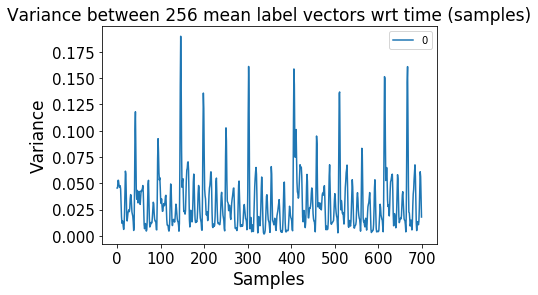

In [10]:
def get_mean_vectors(X, y):
    '''Computes the mean, variance, and std feature vector corresponding to each label'''
    mean_vectors = []
    var_vectors  = []
    std_vectors  = []
    
    for label in range(256):
        mean_vector = X[y==label].mean(axis=0)
        mean_vectors.append(mean_vector)
        
    return np.array(mean_vectors)

mean_vectors = get_mean_vectors(X_train, y_train)
var = mean_vectors.var(axis=0)
plt.figure(figsize=(20,10))
df_var = pd.DataFrame(var)
df_var.plot()
plt.title("Variance between 256 mean label vectors wrt time (samples)",fontsize=17)
plt.xlabel("Samples",fontsize=17)
plt.xticks(fontsize=15, visible=True)
plt.ylabel("Variance",fontsize=17)
plt.yticks(fontsize=15)
plt.show()

The first of those indices are shown below 

In [11]:
np.argpartition(X_train.var(axis=0), -6)[-6:]

array([145, 667, 302, 147, 406, 146], dtype=int64)

We can now plot examples from a new representation focused around some of those peaks (the 5 examples plotted are the same in each plot):

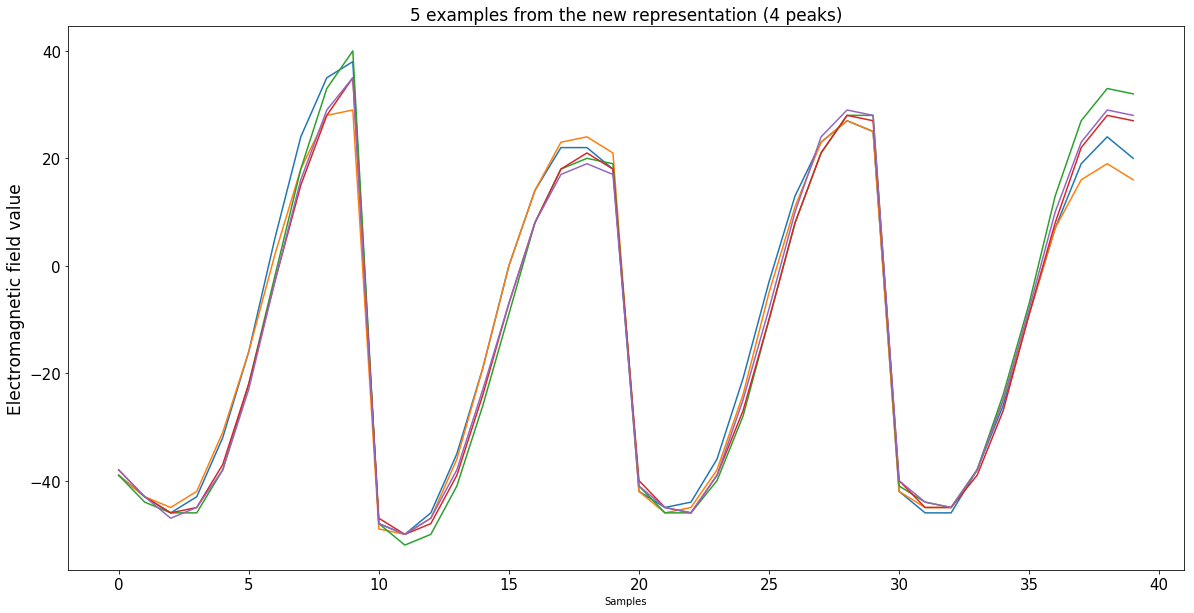

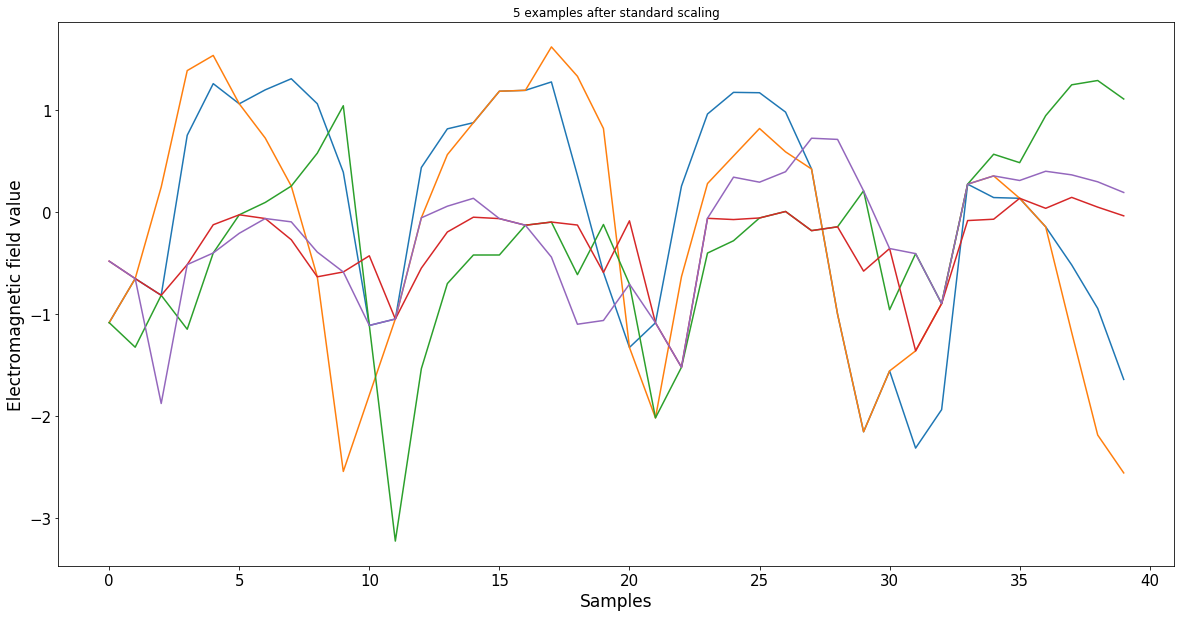

In [12]:
peaks_indices = [145, 667, 302, 406]
new_X = np.concatenate([X_train[:,i-5:i+5] for i in peaks_indices], axis=1)

plt.figure(figsize=(20,10))
for i in range(5): 
    plt.plot([i for i in range(40)], new_X[i])
plt.title("5 examples from the new representation (4 peaks)", fontsize=17)
plt.xlabel("Samples")
plt.xticks(fontsize=15, visible=True)
plt.ylabel("Electromagnetic field value", fontsize=17)
plt.yticks(fontsize=15)
plt.show()


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(new_X, y_train)
new_X_scaled = scaler.transform(new_X)
plt.figure(figsize=(20,10))
for i in range(5): 
    plt.plot([i for i in range(40)], new_X_scaled[i])
plt.title("5 examples after standard scaling")
plt.xlabel("Samples", fontsize=17)
plt.xticks(fontsize=15, visible=True)
plt.ylabel("Electromagnetic field value", fontsize=17)
plt.yticks(fontsize=15)
plt.show()

### Let's look at it more in details

Here is a function that automaticaly find extrema in the traces. After normalization, let us zoom on these :

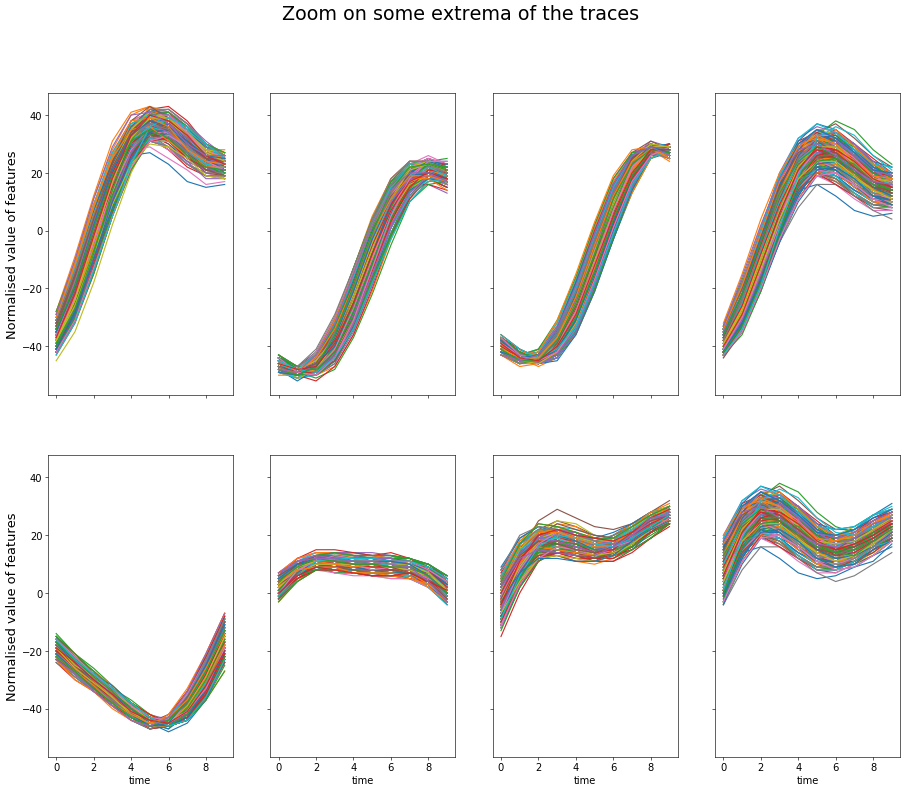

In [13]:
from sklearn.preprocessing import normalize

def plot_minima(minima,X_train,y_train,i,j,axs):
    for k in range(1,256):
            axs[i, j].plot(X_train[np.where(y_train == k)][0][minima-5:minima+5])

example = X_train[0]

local_max = np.r_[True, example[1:] > example[:-1]] & np.r_[example[:-1] > example[1:], True]
local_min = np.r_[True, example[1:] < example[:-1]] & np.r_[example[:-1] < example[1:], True]

maximum_idx = np.where(local_max == True)
minimas_idx = np.where(local_min == True)

n_sub = 0
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
plt.suptitle("Zoom on some extrema of the traces",fontsize=25)
fig.set_size_inches(20,16)
fig.dpi=55

axs.ravel()[n_sub].set_ylabel('Normalised value of features', fontsize=17) 
for maximum in [149,667,302,409]: #timestamps of maxima
    for i in range(1,256):
        axs.ravel()[n_sub].plot(X_train[np.where(y_train == i)][0][maximum-5:maximum+5])
        axs.ravel()[n_sub].tick_params(labelsize=13)
    n_sub += 1
        
axs.ravel()[n_sub].set_ylabel('Normalised value of features', fontsize=17) 
for minimum in [90,130,204,412]: #timestamps of minima
    for i in range(1,256):
        axs.ravel()[n_sub].plot(X_train[np.where(y_train == i)][0][minimum-5:minimum+5])
        axs.ravel()[n_sub].set_xlabel('time', fontsize=13)
        axs.ravel()[n_sub].tick_params(labelsize=13)
    n_sub += 1

plt.show()    

Here are displayed one trace by class. We noticed that we could locate some little differences in the maximums. Indeed, some traces are distinguished from others by their value. It happens more often on the maximum cases, and minimum cases seems to be uninformative. This could be a way to categorize the different traces but moreover to select or create some useful features.

# 4. Baseline solution

### Feature Extractor

We start by implementing a simple feature extrator that will return a new representation of the data. In this simple baseline, we focus on the regions around 4 peaks of variance that we identified during the EDA. We also compute the mean vectors for each label and represent the traces by their euclidean distance to these mean vectors thus reducing the dimension from 700 to 296 (40 for the peaks, 256 for the pairwise distances)

In [14]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fitted = False
        self.mean_vectors = None
        # Indices for which we observed high variance in the data 
        self.peaks_indices = [145, 667, 302, 406]


    def fit(self, X, y):
        self.y = y
        return self

    def transform(self, X):
        new_X = X.copy()
        new_X = np.concatenate([new_X[:,i-5:i+5] for i in self.peaks_indices], axis=1)
        # print(new_X.shape)
        if not self.fitted:
            self.mean_vectors = get_mean_vectors(new_X, self.y)
            self.fitted = True
        #pca_X = self.pca.transform(new_X)
        #new_X = pca_X
        dist_X = np.abs(pairwise_distances(new_X, self.mean_vectors, metric='euclidean'))
        new_X = np.concatenate((new_X, dist_X), axis=1)
        #print('FeatureExtractor debug : new X shape : '+str(new_X.shape))
        return new_X

def get_mean_vectors(X, y):
    mean_vectors = []
    
    for label in range(256):
        mean_vector = X[y==label].mean(axis=0)
        mean_vectors.append(mean_vector)
    
    return np.array(mean_vectors)

def get_sum(v, metric='euclidean'):
    return pairwise_distances(v, metric=metric).sum(axis=0)

Let's visulalise 5 examples (same as before) from our new representation :

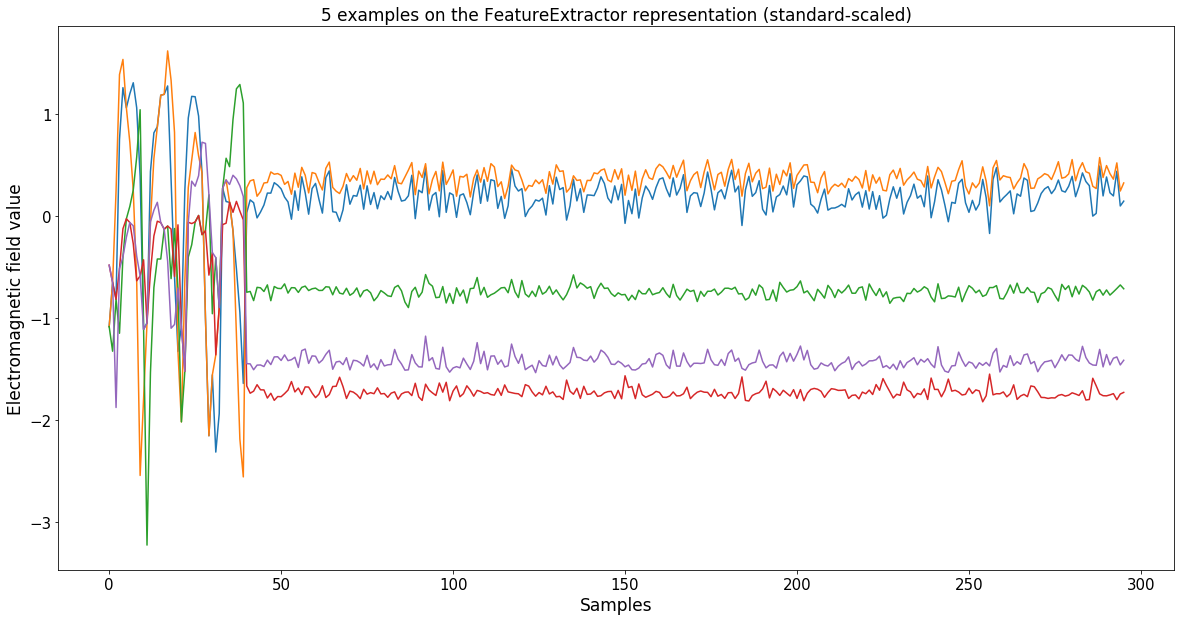

In [15]:
tr = FeatureExtractor()
XX = tr.fit_transform(X_train, y_train)
scaler = StandardScaler()
XX_std = scaler.fit_transform(XX, y_train)

plt.figure(figsize=(20,10))
for i in range(5): 
    plt.plot([i for i in range(296)], XX_std[i])
plt.title("5 examples on the FeatureExtractor representation (standard-scaled)", fontsize=17)
plt.xlabel("Samples", fontsize=17)
plt.xticks(fontsize=15, visible=True)
plt.ylabel("Electromagnetic field value", fontsize=17)
plt.yticks(fontsize=15)
plt.show()

### Classifier

Next we implement a classifier, for this baseline we choose a Naive Bayes classifier. 

In [30]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.ensemble import RandomForestClassifier


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestClassifier()
        
    def fit(self, X, y):
        self.clf.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        y_pred_proba = self.clf.predict_proba(X)
        return y_pred_proba


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from problem import AUTR

We split the data into a training and a validation set, train the model, and test it :

In [33]:
model = make_pipeline(FeatureExtractor(), Classifier())

In [34]:
%time model.fit(X_train, y_train)

KeyboardInterrupt: 

In [20]:
%time predictions = model.predict_proba(X_valid)

Wall time: 12.3 s


Area Under The Rank : 0.636203125


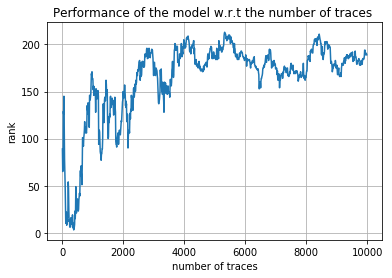

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [28]:
scorer = AUTR()
print("Area Under The Rank : "+str(scorer(labels_valid, predictions)))

ranks = scorer.rankings

x = [ranks[i][0] for i in range(0, ranks.shape[0])]
y = [ranks[i][1] for i in range(0, ranks.shape[0])]
plt.title('Performance of the model w.r.t the number of traces ')
plt.xlabel('number of traces')
plt.ylabel('rank')
plt.grid(True)
plt.plot(x, y)
plt.show()
plt.figure()

To compare : here we launch the same classifier without the feature extraction step :

Area Under The Rank without feature extrator: 0.0667578125


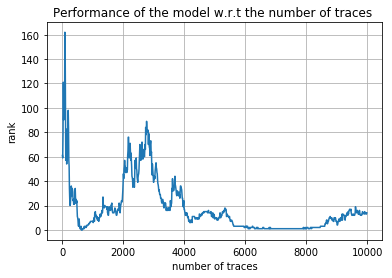

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
clf2 = GaussianNB()
clf2.fit(X_train, y_train)
predictions2 = clf2.predict_proba(X_valid)
scorer2 = AUTR()
print("Area Under The Rank without feature extrator: "+str(scorer2(labels_valid, predictions2)))

ranks = scorer2.rankings

x = [ranks[i][0] for i in range(0, ranks.shape[0])]
y = [ranks[i][1] for i in range(0, ranks.shape[0])]
plt.title('Performance of the model w.r.t the number of traces ')
plt.xlabel('number of traces')
plt.ylabel('rank')
plt.grid(True)
plt.plot(x, y)
plt.show()
plt.figure()

As a final note for this starting kit, we would suggest digging around Neural Networks/Multi Layers Perceptrons, those solutions being highlighted in the article that inspired this challenge.

# 5. Making a RAMP submission

In [44]:
!ramp_test_submission --submission starting_kit

/Users/nour/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Testing Side Channel Attack Challenge
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
FeatureExtractor debug : calling get_mean_vectors
./problem.py:168: RuntimeWarning: divide by zero encountered in log
  key_bytes_proba[i] += np.log(min_proba/2)
Traceback (most recent call last):
  File "/Users/nour/anaconda3/bin/ramp_test_submission", line 11, in <module>
    sys.exit(ramp_test_submission())
  File "/Users/nour/anaconda3/lib/python3.6/site-packages/rampwf/utils/command_line.py", line 93, in ramp_test_submission
    retrain=retrain)
  File "/Users/nour/anaconda3/lib/python3.6/site-packages/rampwf/utils/testing.py"